In [1]:
import numpy as np
import os , csv
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.interpolate import interp1d
from sklearn.decomposition import TruncatedSVD

In [2]:
# Load desired data from 1 session 1 animal
# Note that there are 340 trials in 1 session
# (For more info https://github.com/nsteinme/steinmetz-et-al-2019/wiki/data-files)


data_path = '/media/maria/DATA1/Documents/NeuroMatchAcademy2020_dat/unzipped_files/Richards_2017-10-31.tar'
trials_intervals = np.load(data_path+'/'+'trials.intervals.npy') # in seconds
spike_times = np.load(data_path+'/'+'spikes.times.npy') * 1000 # Unbinned spike times in ms
trials_gocue_times = np.load(data_path+'/'+'trials.goCue_times.npy')
trials_response_choice = np.load(data_path+'/'+'trials.response_choice.npy') # -1 left, 1, right, 0 no response
spontaneous_intervals = np.load(data_path+'/'+'spontaneous.intervals.npy')
trials_response_time = np.load(data_path+'/'+'trials.response_times.npy')
spike_clusters = np.load(data_path+'/'+'spikes.clusters.npy')
site_positions = np.load(data_path+'/'+'channels.sitePositions.npy')
clusters_depths = np.load(data_path+'/'+'clusters.depths.npy')
clusters_annotation = np.load(data_path+'/'+'clusters._phy_annotation.npy')
channel_sites = np.load(data_path+'/'+'channels.site.npy')
channels_brainlocation = pd.read_csv(data_path+'/'+'channels.brainLocation.tsv', sep='\t')
clusters_probes = np.load(data_path+'/'+'clusters.probes.npy')
channels_probe = np.load(data_path+'/'+'channels.probe.npy')
trials_visual_time = np.load(data_path+'/'+'trials.visualStim_times.npy')
visual_times = trials_visual_time
# Behaviour data
wheel_movement = np.load(data_path+'/'+'wheelMoves.type.npy')
wheel_intervals = np.load(data_path+'/'+'wheelMoves.intervals.npy')

In [8]:
trials_intervals
spike_clusters
channel_sites

array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
       [ 71],
      

In [10]:
def get_good_cells(fdirpath): #
    # location in brain of each neuron
    brain_loc = os.path.join(fdirpath, "channels.brainLocation.tsv")

    good_cells = (np.load(os.path.join(fdirpath, "clusters._phy_annotation.npy")) >= 2 ).flatten()
    clust_channel = np.load(os.path.join(fdirpath, "clusters.peakChannel.npy")).astype(int) - 1
    br = []
    with open(brain_loc, 'r') as tsv:
        tsvin = csv.reader(tsv, delimiter="\t")
        k=0
        for row in tsvin:
            if k>0:
                br.append(row[-1])
            k+=1
    br = np.array(br)
    good_cells = np.logical_and(good_cells, clust_channel.flatten()<len(br))
    brain_region = br[clust_channel[:,0]]


    return good_cells, brain_region, br

def bin_spikes(spike_times,spike_clusters,clusters_annotation, bin_size = 10):

    # Using clusters._phy_annotation.npy obtain valid clusters (i.e. >= 2)
    # valid_clusters_idx = np.array(np.where(clusters_annotation>=2))[0]

    spike_time_cells = np.empty(len(clusters_annotation), dtype=object) # Initalise empty object
    for i in (np.arange(len(np.unique(spike_clusters)))):
      # Create a spike time arrays, where each array in the array is a spike time of a cell
      spike_time_cells[i] = spike_times[(np.where(spike_clusters == i)[0])]

    # Bin spike times into 10ms intervals
    spike_time_binned = np.empty(len(np.unique(spike_clusters)), dtype=object) # Initalise empty object
    sum_spikes = np.empty(len(np.unique(spike_clusters)), dtype=object) # Initalise empty object

    for cell_num in np.arange(len(spike_time_cells)):
        spike_time_hist = np.histogram(spike_time_cells[cell_num],bins = np.arange(0,np.floor(spike_time_cells[cell_num][-1]),bin_size))
        spike_time_binned[cell_num] = spike_time_hist[0]
        sum_spikes[cell_num] = np.sum(spike_time_binned[cell_num])

    cell_spikes_max = np.argmax(sum_spikes) # cell with the maximum number of spikes for plotting purposes

    # Spike_time_binned returns binned spikes sorted into cells
    # Spike_time_cells returns UNbinned spikes sorted into cells
    # cell_spikes_max returns a single cell index that has the max number of spikes (i.e most active cell)
    return spike_time_binned, spike_time_cells, cell_spikes_max

def sort_cells_trials(spike_time_binned,spike_time_cells, trials_intervals,trials_visual_time,epoch_duration = 400 , bin_size = 10):
    # Epoch duration is defined as the period after the visual stimulus

    # Sort into trials
    spike_time_binned_trial = np.empty(len(spike_time_binned), dtype=object)
    spike_time_binned_trial_response = np.empty(len(spike_time_binned), dtype=object)
    for cell_num in np.arange(len(spike_time_binned)):
        spike_time_binned_trial[cell_num] = np.empty(len(trials_intervals), dtype=object)
        spike_time_binned_trial_response[cell_num] = np.empty(len(trials_intervals), dtype=object)

        for i,trials_start_end in enumerate(trials_intervals):
            # Sort spikes into their trial numbers.
            spike_time_binned_trial[cell_num][i] = spike_time_binned[cell_num][ int(np.floor(trials_start_end[0]*(1000/bin_size))) : int(np.floor(trials_start_end[1]*(1000/bin_size)))]
            # Using visual onset to splice a trial into visual onset : visual onset +400ms
            spike_time_binned_trial_response[cell_num][i] = spike_time_binned[cell_num][(int(np.floor(trials_visual_time[i]*(1000/bin_size)))) : (int(np.floor(trials_visual_time[i]*(1000/bin_size)) + epoch_duration))]

    # spike_time_binned_trial returns spikes that are sorted into cells and trials
    # spike_time_binned_trial_response returns spikes that are sorted into cells and trials, and spliced accordingly to desired epoch duration post-visual stim onset

    return spike_time_binned_trial, spike_time_binned_trial_response

def sort_cells_trial_types(spike_time_binned_trial_response,trials_intervals,trials_response_choice):

    # Input: spike_time_binned_trial_response can be any spike_time_binned variable regardless of whether it has been spliced.

    # Get response choice trials types
    right_choice_trials = np.where(trials_response_choice == -1)[0]
    left_choice_trials = np.where(trials_response_choice == 1)[0]
    no_response_choice_trials = np.where(trials_response_choice == 0)[0]

    # Sort trials into response type
    left_spike_time_response = np.empty(len(spike_time_binned_trial_response), dtype=object)
    right_spike_time_response = np.empty(len(spike_time_binned_trial_response), dtype=object)
    no_response_spike_time_response = np.empty(len(spike_time_binned_trial_response), dtype=object)

    for cell_num in np.arange(len(spike_time_binned_trial_response)):
        left_spike_time_response[cell_num] = spike_time_binned_trial_response[cell_num][left_choice_trials]
        right_spike_time_response[cell_num] = spike_time_binned_trial_response[cell_num][right_choice_trials]
        no_response_spike_time_response[cell_num] = spike_time_binned_trial_response[cell_num][no_response_choice_trials]

    # Returns 3 variables by sorting the spike_time_binned variable into left, right no response trials
    return left_spike_time_response, right_spike_time_response, no_response_spike_time_response

def sort_cells_brain_regions(spike_time_response, brain_regions, clusters_annotation, input_region):
    valid_brain_region_boo = np.array([])
    regional_spike_time_response = np.empty(len(input_region), dtype=object)
    for i in np.arange(len(input_region)):
        # Get brain regions that correponds to the desired region
        valid_brain_region_boo = (np.reshape( (clusters_annotation >= 2),(-1) ) & np.reshape( (brain_regions == input_region[i]),(-1) ))
        # Index the spike time to get spikes from desired regions
        regional_spike_time_response[i] = spike_time_response[valid_brain_region_boo]

    # Merge spikes across all regions
    merged_region_spikes = []
    for i in np.arange(len(regional_spike_time_response)):
        merged_region_spikes = np.append(merged_region_spikes, regional_spike_time_response[i])

    # Return spike time sorted into regions and merged across all regions
    # Indexing: regional_spike_times[cell_num][trial_num][# of bins]
    return merged_region_spikes

In [11]:
good_cells, brain_regions, br=get_good_cells(data_path)
spike_time_binned, spike_time_cells, cell_spikes_max = bin_spikes(spike_times,spike_clusters,clusters_annotation,10)
spike_time_binned_trial, spike_time_binned_trial_response = sort_cells_trials(spike_time_binned,spike_time_cells, trials_intervals,trials_visual_time)
left_spike_time_response, right_spike_time_response, no_response_spike_time_response = sort_cells_trial_types(spike_time_binned_trial_response,trials_intervals,trials_response_choice)
regional_left_spike = sort_cells_brain_regions(left_spike_time_response, brain_regions, clusters_annotation, ['SCs'])

In [18]:
regional_left_spike = sort_cells_brain_regions(left_spike_time_response, brain_regions, clusters_annotation, ['SCs'])

In [23]:
spike_time_binned_trial_response[20].shape

(260,)

In [27]:
260/75

3.466666666666667

In [33]:
left_spike_time_response[0]

array([array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0,

In [32]:
regional_left_spike[60]

array([array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1,
              0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
              0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0,
              1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 0, 1, 0, 1, 1,
              2, 0, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
              0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 3, 1, 2, 1, 0, 1, 2, 0, 0, 0,
              0, 0, 0, 2, 1, 0, 0, 2, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 0, 1,
              1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0,
              0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
              0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 1, 0, 0, 1, 0, 0, 0,

In [26]:
from netrep.metrics import LinearMetric

# Rotationally invariant metric (fully regularized).
metric = LinearMetric(alpha=1.0, center_columns=True)

In [50]:
left_spike_time_response[:][0].reshape(99,)

array([array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
              0, 0, 0, 0, 0, 0, 0, 0, 0,

In [54]:
trial_0=[]
trial_1=[]
for j in range(0,778):
    #print(left_spike_time_response[j][0])
    trial_0.append(left_spike_time_response[j][0])
    trial_1.append(left_spike_time_response[j][1])
trial_0=np.array(trial_0).T
trial_1=np.array(trial_1).T
print(trial_0.shape)
print(trial_1.shape)

(400, 778)
(400, 778)


In [55]:
# Fit alignment transformations.
metric.fit(trial_0,trial_1)

# Apply alignment transformations.
X_aligned, Y_aligned = metric.transform(trial_0,trial_1)

In [56]:
X_aligned.shape

(400, 778)

In [57]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pcs_X=pca.fit_transform(X_aligned)
pcs_Y=pca.fit_transform(Y_aligned)

In [58]:
pcs_X.shape

(400, 3)

<IPython.core.display.Javascript object>


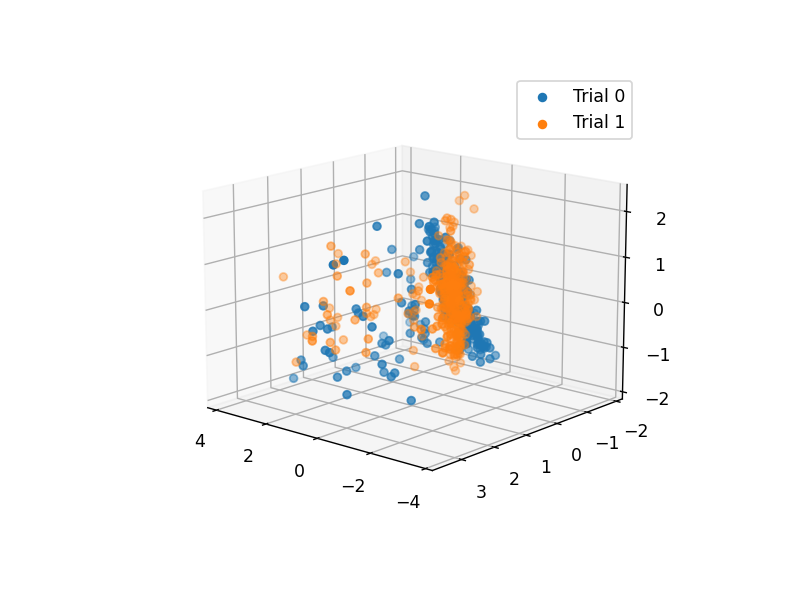

/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  if __name__ == '__main__':


In [62]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(pcs_X[:,0],pcs_X[:,1],pcs_X[:,2],label='Trial 0')
ax.scatter(pcs_Y[:,0],pcs_Y[:,1],pcs_Y[:,2],label='Trial 1')
ax.legend()

plt.show()